In [6]:
import os
import pandas as pd

# Configuración de directorio y archivos
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\GIT-3\build\Release"
st_csv_path = os.path.join(sim_dir, "nt.csv")
output_mac_path = os.path.join(sim_dir, "att.mac")

# Leer los datos de ST.csv
df_st = pd.read_csv(st_csv_path)

# Crear el archivo .mac
with open(output_mac_path, "w") as mac_file:
    # Encabezado común
    mac_file.write("/run/initialize\n")

    # Generar comandos para cada fila en el CSV
    for _, row in df_st.iterrows():
        energy = row["Energy"]
        thickness = row["Optimal_t"]  # Se asume que ya está en nanómetros

        mac_file.write(f"/gun/energy {energy} keV\n")
        mac_file.write("/Pgun/Angle 0\n")
        mac_file.write("/Pgun/Z -50 cm\n")
        mac_file.write(f"/det/t {thickness} nm\n")
        mac_file.write("/run/reinitializeGeometry\n")
        mac_file.write("/run/beamOn 1000000\n\n")

print(f"Archivo macro generado en: {output_mac_path}")


Archivo macro generado en: C:\Users\conej\Documents\Universidad\Geant4\Projects\GIT-3\build\Release\att.mac


In [9]:
import os
import uproot
import numpy as np
import pandas as pd

# Configuración
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\GIT-3\build\Release"
st_csv_path = os.path.join(sim_dir, "nt.csv")
num_simulations = 41  # Número total de archivos a procesar

# Leer el archivo ST.csv para obtener energías y grosores
df_st = pd.read_csv(st_csv_path)

# Verificar que el archivo tenga al menos tantos registros como num_simulations
if len(df_st) < num_simulations:
    raise ValueError("El archivo ST.csv tiene menos entradas que el número de simulaciones.")

# Función para procesar el archivo ROOT y obtener hits y energía promedio
def process_root_file(root_filename):
    file_path = os.path.join(sim_dir, root_filename)
    if not os.path.isfile(file_path):
        return -1, -1  # Si el archivo no existe, devolver valores inválidos
    
    try:
        with uproot.open(file_path) as file:
            tree = file["G4_PCM"]  # Asegúrate de que el nombre del TTree es correcto
            df = tree.arrays(library="pd")  # Convertir a DataFrame
        
        # Filtrar las energías mayores que 0
        df_filtered = df[df['Energy'] > 0]
        hits = len(df_filtered)
        if hits == 0:
            return 0, 0
        
        # Calcular el promedio de las energías
        avener = df_filtered['Energy'].mean()
        return hits, avener
    except Exception as e:
        print(f"Error procesando {root_filename}: {e}")
        return -1, -1

# Función para calcular el coeficiente de atenuación usando valores de grosor específicos
def calculate_coeff(thickness, avener, energy, hits):
    # Thickness ya está en cm
    coeff = (-1 / (thickness)) * np.log((avener / energy) * (hits / 1000000)) / 1.02
    return coeff

# Procesar todos los archivos ROOT y calcular coeficientes
data = []
for i in range(num_simulations):
    root_filename = f"Sim{i}.root"
    # Leer energía y grosor específicos de la fila correspondiente en el DataFrame
    energy = df_st.iloc[i]["Energy"]
    thickness = df_st.iloc[i]["Optimal_t"] / 1e7  # Convertir thickness de nm a cm
    hits, avener = process_root_file(root_filename)
    
    if hits > 0 and avener > 0:
        coeff = calculate_coeff(thickness, avener, energy, hits)
        data.append([energy, coeff])
    else:
        print(f"Archivo {root_filename} no pudo ser procesado correctamente.")

# Convertir los resultados a un DataFrame
df_results = pd.DataFrame(data, columns=["Energy (keV)", "MAC"])

# Guardar los resultados en un archivo CSV
output_csv = os.path.join(sim_dir, "nt1mac.csv")
df_results.to_csv(output_csv, index=False)

print(f"Archivo CSV guardado en: {output_csv}")


Archivo CSV guardado en: C:\Users\conej\Documents\Universidad\Geant4\Projects\GIT-3\build\Release\nt1mac.csv


In [13]:
import os
import uproot
import numpy as np
import pandas as pd

# Configuración
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\GIT-3\build\Release"
num_simulations = 41  # Sim0.root hasta Sim16.root (17 archivos)
thickness = 3.15*2  # Thickness en cm
energies = np.arange(20, 105, 5)  # Energías de 20 keV a 100 keV

# Función para procesar el archivo ROOT y obtener hits y energía promedio
def process_root_file(root_filename):
    file_path = os.path.join(sim_dir, root_filename)
    if not os.path.isfile(file_path):
        return -1, -1  # Si el archivo no existe, devolver valores inválidos
    
    try:
        with uproot.open(file_path) as file:
            tree = file["G4_PCM"]  # Asegúrate que el nombre del TTree es correcto
            df = tree.arrays(library="pd")  # Convertir a DataFrame
        
        # Filtrar las energías mayores que 0
        df_filtered = df[df['Energy'] > 0]
        hits = len(df_filtered)
        if hits == 0:
            return 0, 0
        
        # Calcular el promedio de las energías
        avener = df_filtered['Energy'].mean()
        return hits, avener
    except Exception as e:
        print(f"Error procesando {root_filename}: {e}")
        return -1, -1

# Función para calcular el coeficiente de atenuación
def calculate_coeff(thickness, avener, energy, hits):
    # Thickness ya está en cm
    coeff = (-1 / thickness) * np.log((avener / energy) * (hits / 1000000)) / 1.03
    return coeff

# Procesar todos los archivos ROOT y calcular coeficientes
data = []
for i in range(num_simulations):
    root_filename = f"Sim{i}.root"
    energy = energies[i]
    hits, avener = process_root_file(root_filename)
    
    if hits > 0 and avener > 0:
        coeff = calculate_coeff(thickness, avener, energy, hits)
        data.append([energy, coeff])
    else:
        print(f"Archivo {root_filename} no pudo ser procesado correctamente.")

# Convertir los resultados a un DataFrame
df_results = pd.DataFrame(data, columns=["Energy (keV)", "Attenuation Coeff"])

# Guardar los resultados en un archivo CSV
output_csv = os.path.join(sim_dir, "attenuation_coefficients.csv")
df_results.to_csv(output_csv, index=False)

print(f"Archivo CSV guardado en: {output_csv}")


IndexError: index 17 is out of bounds for axis 0 with size 17

In [4]:
TS = 0.15*2
TM = 2.5*2
TA = 0.5*2
skinD = 1.09
muscleD = 1.05
adiposeD = 0.95
thick = TS+TM+TA
print(thick)

6.3


In [6]:
(skinD*(TS/thick))+(muscleD*(TM/thick))+(adiposeD*(TA/thick))

1.036031746031746

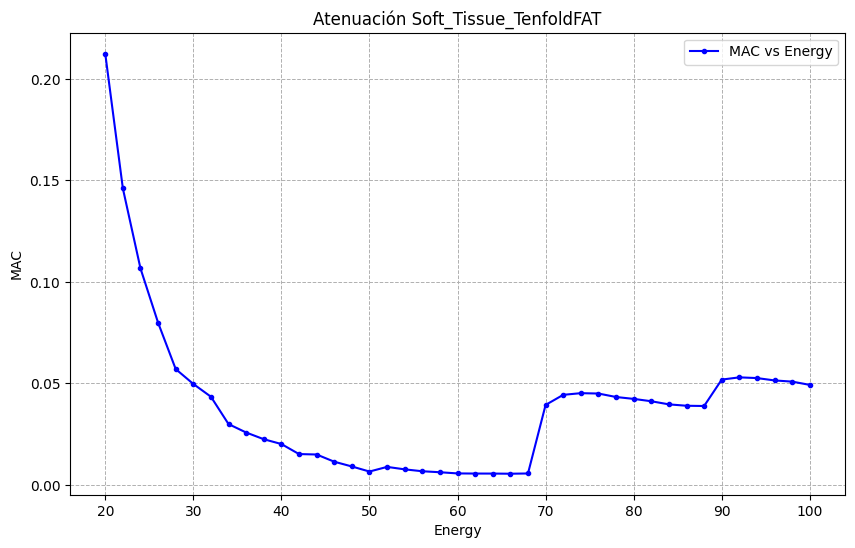

In [10]:
import matplotlib.pyplot as plt

# Leer el archivo CSV
csv_file = 'nt1mac.csv'
df = pd.read_csv(csv_file)

# Asumir que el archivo tiene columnas 'Energy' y 'Optimal_t'
energy_col = 'Energy (keV)'
optimal_t_col = 'MAC'

# Comprobar que las columnas están presentes
if energy_col not in df.columns or optimal_t_col not in df.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in the CSV file")

# Extraer los datos
energy = df[energy_col].values
optimal_t = df[optimal_t_col].values

# Filtrar valores de 'Optimal_t' adyacentes repetidos, manteniendo 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

energy_filtered, optimal_t_filtered = remove_repeated_thickness(energy, optimal_t)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos filtrados
plt.plot(energy_filtered, optimal_t_filtered, '.-', color='blue', label='MAC vs Energy')

# # Configurar escalas logarítmicas
# plt.xscale('log')
# plt.yscale('log')

# Etiquetas y título
plt.xlabel('Energy')
plt.ylabel('MAC')
plt.title('Atenuación Soft_Tissue_TenfoldFAT')
plt.legend()

# Mostrar la cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# # Guardar el gráfico como archivo PNG
# plt.savefig('filtered_log_log_plot.png')

# Mostrar el gráfico
plt.show()


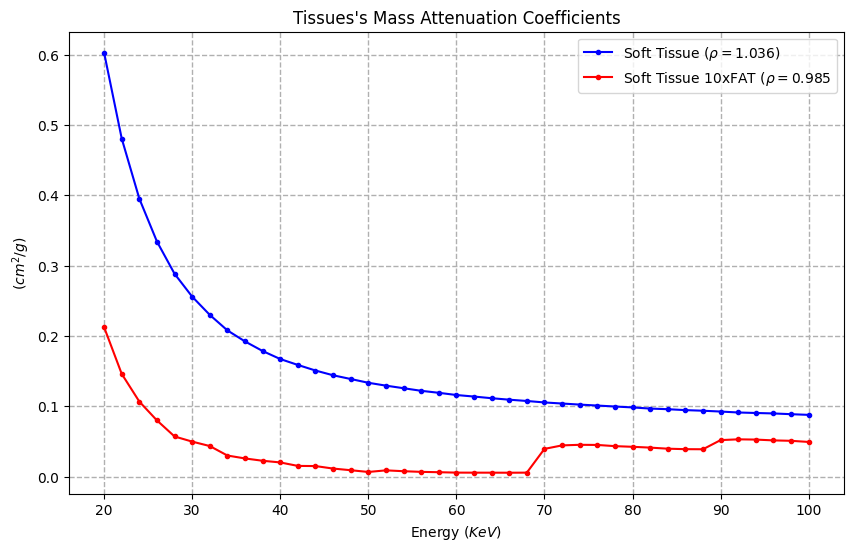

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Función para filtrar valores repetidos de 'Optimal_t' y mantener 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

# Leer el primer archivo CSV
csv_file_1 = 'ntmac.csv'
df1 = pd.read_csv(csv_file_1)

# Leer el segundo archivo CSV
csv_file_2 = 'nt1mac.csv'
df2 = pd.read_csv(csv_file_2)

# Asumir que ambos archivos tienen las columnas 'Energy' y 'Attenuation Coeff'
energy_col = 'Energy (keV)'
optimal_t_col = 'MAC'

# Comprobar que las columnas están presentes en ambos archivos
if energy_col not in df1.columns or optimal_t_col not in df1.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in '{csv_file_1}'")
if energy_col not in df2.columns or optimal_t_col not in df2.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in '{csv_file_2}'")

# Extraer los datos del primer archivo
energy1 = df1[energy_col].values
optimal_t1 = df1[optimal_t_col].values
energy1_filtered, optimal_t1_filtered = remove_repeated_thickness(energy1, optimal_t1)

# Extraer los datos del segundo archivo
energy2 = df2[energy_col].values
optimal_t2 = df2[optimal_t_col].values
energy2_filtered, optimal_t2_filtered = remove_repeated_thickness(energy2, optimal_t2)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos del primer archivo
plt.plot(energy1_filtered, optimal_t1_filtered, '.-', color='blue', label = r'Soft Tissue ($\rho = 1.036$)')

# Graficar los datos del segundo archivo
plt.plot(energy2_filtered, optimal_t2_filtered, '.-', color='red', label=r'Soft Tissue 10xFAT ($\rho = 0.985$')

# Configurar escalas logarítmicas (descomentar si es necesario)
# plt.xscale('log')
# plt.yscale('log')

# Etiquetas y título
title = r"Tissues's Mass Attenuation Coefficients"
x_label = r"Energy ($KeV$)"
y_label = r"($cm^2/g$)"


plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

# Añadir leyenda
plt.legend()

# Mostrar la cuadrícula con mayor grosor para mayor legibilidad
plt.grid(True, which='both', linestyle='--', linewidth=1.0)

plt.savefig("MAC_SoftTissue" + '.png', dpi=400)

# Mostrar el gráfico
plt.show()


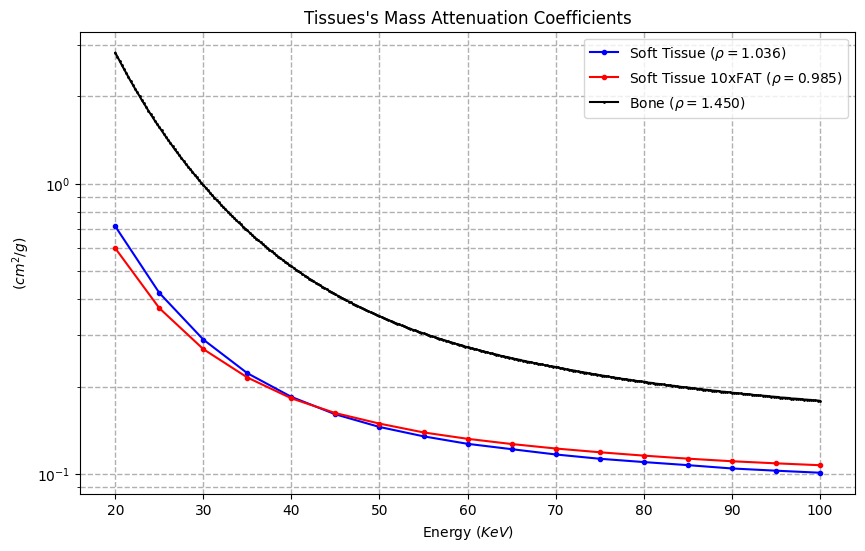

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Función para filtrar valores repetidos de 'Optimal_t' y mantener 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

# Leer los archivos CSV
csv_file_1 = 'SoftTissue.csv'
csv_file_2 = 'Soft_Tissue_TEN.csv'
csv_file_3 = 'bone.csv'  # Archivo adicional para hueso

df1 = pd.read_csv(csv_file_1)
df2 = pd.read_csv(csv_file_2)
df3 = pd.read_csv(csv_file_3)

# Asumir que todos los archivos tienen las columnas 'Energy' y 'Attenuation Coeff'
energy_col = 'Energy (keV)'
optimal_t_col = 'Attenuation Coeff'

# Comprobar que las columnas están presentes en todos los archivos
for csv_file, df in zip([csv_file_1, csv_file_2, csv_file_3], [df1, df2, df3]):
    if energy_col not in df.columns or optimal_t_col not in df.columns:
        raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in '{csv_file}'")

# Extraer y filtrar datos para el primer archivo
energy1 = df1[energy_col].values
optimal_t1 = df1[optimal_t_col].values
energy1_filtered, optimal_t1_filtered = remove_repeated_thickness(energy1, optimal_t1)

# Extraer y filtrar datos para el segundo archivo
energy2 = df2[energy_col].values
optimal_t2 = df2[optimal_t_col].values
energy2_filtered, optimal_t2_filtered = remove_repeated_thickness(energy2, optimal_t2)

# Extraer y filtrar datos para el tercer archivo (bone.csv)
energy3 = df3[energy_col].values
optimal_t3 = df3[optimal_t_col].values
energy3_filtered, optimal_t3_filtered = remove_repeated_thickness(energy3, optimal_t3)

# Filtrar las energías en el rango deseado (20 a 100 keV)
def filter_range(energy, attenuation, min_val=20, max_val=100):
    mask = (energy >= min_val) & (energy <= max_val)
    return energy[mask], attenuation[mask]

energy1_filtered, optimal_t1_filtered = filter_range(energy1_filtered, optimal_t1_filtered)
energy2_filtered, optimal_t2_filtered = filter_range(energy2_filtered, optimal_t2_filtered)
energy3_filtered, optimal_t3_filtered = filter_range(energy3_filtered, optimal_t3_filtered)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos del primer archivo
plt.plot(energy1_filtered, optimal_t1_filtered, '.-', color='blue', label=r'Soft Tissue ($\rho = 1.036$)')

# Graficar los datos del segundo archivo
plt.plot(energy2_filtered, optimal_t2_filtered, '.-', color='red', label=r'Soft Tissue 10xFAT ($\rho = 0.985$)')

# Graficar los datos del tercer archivo
plt.plot(energy3_filtered, optimal_t3_filtered, 'o-', markersize=1, color='black', label=r'Bone ($\rho = 1.450$)')

# Configurar escalas logarítmicas (descomentar si es necesario)
# plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
title = r"Tissues's Mass Attenuation Coefficients"
x_label = r"Energy ($KeV$)"
y_label = r"($cm^2/g$)"

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

# Añadir leyenda
plt.legend()

# Mostrar la cuadrícula con mayor grosor para mayor legibilidad
plt.grid(True, which='both', linestyle='--', linewidth=1.0)

plt.savefig("MAC_Tissue.png", dpi=400)

# Mostrar el gráfico
plt.show()


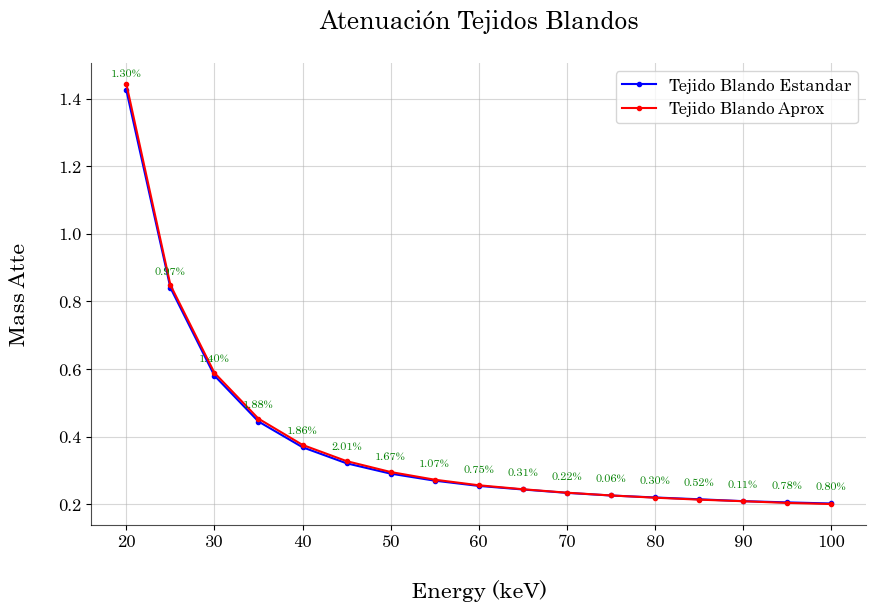

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Función para filtrar valores repetidos de 'Optimal_t' y mantener 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

# Leer el primer archivo CSV
csv_file_1 = 'SoftTissue.csv'
df1 = pd.read_csv(csv_file_1)

# Leer el segundo archivo CSV
csv_file_2 = 'Soft_Tissue_Aprox.csv'
df2 = pd.read_csv(csv_file_2)

# Asumir que ambos archivos tienen las columnas 'Energy' y 'Attenuation Coeff'
energy_col = 'Energy (keV)'
optimal_t_col = 'Attenuation Coeff'

# Comprobar que las columnas están presentes en ambos archivos
if energy_col not in df1.columns or optimal_t_col not in df1.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in '{csv_file_1}'")
if energy_col not in df2.columns or optimal_t_col not in df2.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in '{csv_file_2}'")

# Extraer los datos del primer archivo
energy1 = df1[energy_col].values
optimal_t1 = df1[optimal_t_col].values
energy1_filtered, optimal_t1_filtered = remove_repeated_thickness(energy1, optimal_t1)

optimal_t1_filtered = optimal_t1_filtered*2

# Extraer los datos del segundo archivo
energy2 = df2[energy_col].values
optimal_t2 = df2[optimal_t_col].values
energy2_filtered, optimal_t2_filtered = remove_repeated_thickness(energy2, optimal_t2)

# Asegurarse de que las longitudes de los datos coincidan
if len(energy1_filtered) != len(energy2_filtered):
    raise ValueError("The filtered energy data from both files have different lengths.")

# Calcular el error porcentual entre los valores óptimos de atenuación
percentual_error = np.abs((optimal_t1_filtered - optimal_t2_filtered) / optimal_t1_filtered) * 100

# Configuración de estilo
SIZE_DEFAULT = 12
SIZE_LARGE = 16

plt.rc("font", family='Century')  
plt.rc("font", weight="normal")  
plt.rc("font", size=SIZE_DEFAULT)  
plt.rc("axes", titlesize=SIZE_LARGE + 2)  
plt.rc("axes", labelsize=SIZE_LARGE)  
plt.rc("xtick", labelsize=SIZE_DEFAULT)  
plt.rc("ytick", labelsize=SIZE_DEFAULT)  

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos del primer archivo
plt.plot(energy1_filtered, optimal_t1_filtered, '.-', color='blue', label='Tejido Blando Estandar')

# Graficar los datos del segundo archivo
plt.plot(energy2_filtered, optimal_t2_filtered, '.-', color='red', label='Tejido Blando Aprox')

# Añadir el error porcentual como etiqueta
for i, (x, err) in enumerate(zip(energy1_filtered, percentual_error)):
    plt.annotate(f'{err:.2f}%', (x, optimal_t1_filtered[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='green')

# Etiquetas y título sin negritas
plt.xlabel('Energy (keV)', labelpad=21)
plt.ylabel('Mass Atte', labelpad=21)
plt.title('Atenuación Tejidos Blandos', pad=25)

# Configuración de cuadrícula
plt.grid(True, alpha=0.5)

# Configuración de los ejes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_alpha(0.3)
ax.spines['right'].set_alpha(0.3)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [17]:
np.average(percentual_error)

0.9416845979934656

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Función para filtrar valores repetidos de 'Optimal_t' y mantener 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

# Leer los archivos CSV
csv_file_1 = 'SoftTissue.csv'
csv_file_2 = 'STmac.csv'
csv_file_3 = 'bone.csv'  # Archivo adicional para hueso

df1 = pd.read_csv(csv_file_1)
df2 = pd.read_csv(csv_file_2)
df3 = pd.read_csv(csv_file_3)

# Asumir que todos los archivos tienen las columnas 'Energy' y 'Attenuation Coeff'
energy_col = 'Energy (keV)'
optimal_t_col = 'Attenuation Coeff'

# Comprobar que las columnas están presentes en todos los archivos
for csv_file, df in zip([csv_file_1, csv_file_2, csv_file_3], [df1, df2, df3]):
    if energy_col not in df.columns or optimal_t_col not in df.columns:
        raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in '{csv_file}'")

# Extraer y filtrar datos para el primer archivo
energy1 = df1[energy_col].values
optimal_t1 = df1[optimal_t_col].values
energy1_filtered, optimal_t1_filtered = remove_repeated_thickness(energy1, optimal_t1)

# Extraer y filtrar datos para el segundo archivo
energy2 = df2[energy_col].values
optimal_t2 = df2[optimal_t_col].values
energy2_filtered, optimal_t2_filtered = remove_repeated_thickness(energy2, optimal_t2)

# Extraer y filtrar datos para el tercer archivo (bone.csv)
energy3 = df3[energy_col].values
optimal_t3 = df3[optimal_t_col].values
energy3_filtered, optimal_t3_filtered = remove_repeated_thickness(energy3, optimal_t3)

# Filtrar las energías en el rango deseado (20 a 100 keV)
def filter_range(energy, attenuation, min_val=20, max_val=100):
    mask = (energy >= min_val) & (energy <= max_val)
    return energy[mask], attenuation[mask]

energy1_filtered, optimal_t1_filtered = filter_range(energy1_filtered, optimal_t1_filtered)
energy2_filtered, optimal_t2_filtered = filter_range(energy2_filtered, optimal_t2_filtered)
energy3_filtered, optimal_t3_filtered = filter_range(energy3_filtered, optimal_t3_filtered)

# Asegurarse de que las longitudes de los datos coincidan
if len(energy1_filtered) != len(energy2_filtered):
    raise ValueError("The filtered energy data from both Soft Tissue files have different lengths.")

# Calcular el error porcentual entre los valores de atenuación
percentual_error = np.abs((optimal_t1_filtered - optimal_t2_filtered) / optimal_t1_filtered) * 100

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos del primer archivo
plt.plot(energy1_filtered, optimal_t1_filtered, '.-', color='blue', label=r'Soft Tissue ($\rho = 1.036$)')

# Graficar los datos del segundo archivo
plt.plot(energy2_filtered, optimal_t2_filtered, '.-', color='red', label=r'Soft Tissue 10xFAT ($\rho = 0.985$)')

# Graficar los datos del tercer archivo
plt.plot(energy3_filtered, optimal_t3_filtered, 'o-', markersize=0.5, color='black', label=r'Bone ($\rho = 1.450$)')

# Graficar el error porcentual entre los dos primeros archivos (tejido blando)
for i, (x, err) in enumerate(zip(energy1_filtered, percentual_error)):
    plt.annotate(f'{err:.2f}%', (x, optimal_t1_filtered[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='green')

# Configurar escalas logarítmicas
# plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
plt.xlabel(r"Energy ($KeV$)")
plt.ylabel(r"Attenuation Coefficient ($cm^2/g$)")
plt.title(r"Tissues' Mass Attenuation Coefficients")

# Añadir leyenda
plt.legend()

# Mostrar la cuadrícula con mayor grosor para mayor legibilidad
plt.grid(True, which='both', linestyle='--', linewidth=1.0)

# Guardar el gráfico en un archivo
plt.savefig("MAC_Tissue_with_error.png", dpi=900)

# Mostrar el gráfico
plt.show()


ValueError: The filtered energy data from both Soft Tissue files have different lengths.